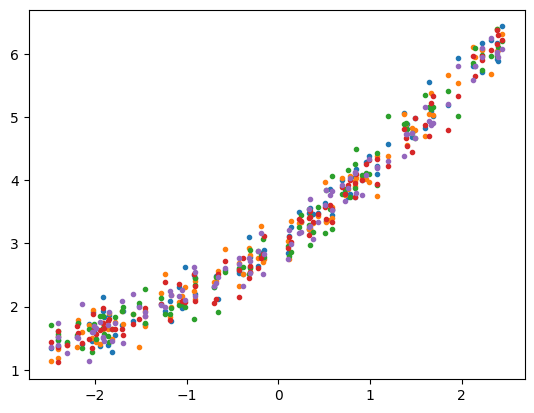

In [48]:
from matplotlib import pyplot as plt
import numpy as np
import torch

def bent_activation(x):
    return (np.sqrt(x ** 2 + 1) - 1) / 2 + x

task_list = [
    bent_activation,
    bent_activation,
    bent_activation,
    bent_activation,
    bent_activation,
]

input_dim = 1

# generate data
np.random.seed(0)
x_train = (np.random.rand(100, input_dim) - 0.5) * 5.0
x_valid = (np.random.rand(50, input_dim) - 0.5) * 5.0

delta_mag = 0.20
offset = 3.0

y_train = np.zeros([x_train.shape[0], 0])
y_valid = np.zeros([x_valid.shape[0], 0])
for task in task_list:
    y_train = np.hstack([y_train, task(x_train) + np.random.randn(x_train.shape[0], x_train.shape[1]) * delta_mag + offset])
    y_valid = np.hstack([y_valid, task(x_valid) + np.random.randn(x_valid.shape[0], x_valid.shape[1]) * delta_mag + offset])

for i, _ in enumerate(task_list):
    plt.plot(x_train, y_train[:, i], '.')

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

In [50]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import sparsenn

input_dim = 1
hidden_dim = (16, 16, )
output_dim = len(task_list)
# model = sparsenn.RegularizedMLP(input_dim, hidden_dim, output_dim)
model = sparsenn.MonotonicRegularizedMLP(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Training loop
lmbda_reg = 1e-2
n_epoch = 20000
model.train()
for epoch in range(n_epoch):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    reg_loss = model.regularization_loss()
    total_loss = loss + lmbda_reg * reg_loss  # np.sqrt(epoch)
    total_loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}], Loss: {loss.item():.4f}, Reg Loss: {reg_loss.item():.4f}')

Epoch [500/20000], Loss: 0.8542, Reg Loss: 123.7130
Epoch [1000/20000], Loss: 0.5196, Reg Loss: 101.4413
Epoch [1500/20000], Loss: 0.3487, Reg Loss: 88.9854
Epoch [2000/20000], Loss: 0.1394, Reg Loss: 80.0445
Epoch [2500/20000], Loss: 0.6317, Reg Loss: 73.5307
Epoch [3000/20000], Loss: 0.0473, Reg Loss: 66.5772
Epoch [3500/20000], Loss: 0.0774, Reg Loss: 59.2855
Epoch [4000/20000], Loss: 0.0441, Reg Loss: 53.0904
Epoch [4500/20000], Loss: 0.0409, Reg Loss: 47.1294
Epoch [5000/20000], Loss: 0.0403, Reg Loss: 41.7361
Epoch [5500/20000], Loss: 0.0394, Reg Loss: 35.5178
Epoch [6000/20000], Loss: 0.0389, Reg Loss: 28.3936
Epoch [6500/20000], Loss: 0.0403, Reg Loss: 25.6830
Epoch [7000/20000], Loss: 0.0379, Reg Loss: 22.3135
Epoch [7500/20000], Loss: 0.0380, Reg Loss: 21.4990
Epoch [8000/20000], Loss: 0.0384, Reg Loss: 19.7207
Epoch [8500/20000], Loss: 0.0379, Reg Loss: 18.0699
Epoch [9000/20000], Loss: 0.0378, Reg Loss: 16.6465
Epoch [9500/20000], Loss: 0.0384, Reg Loss: 15.2913
Epoch [1000

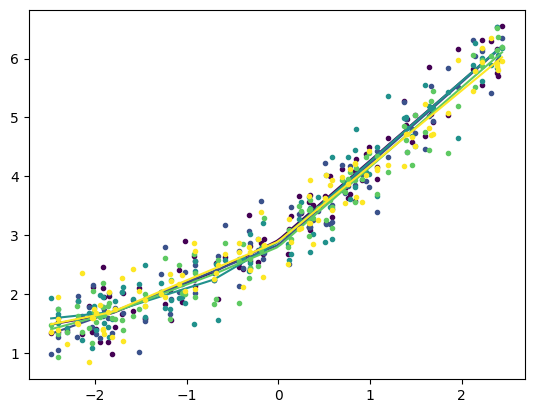

In [47]:
from matplotlib import cm

model.eval()

x_arr = torch.linspace(x_train.min(), x_train.max(), 101)
with torch.no_grad():
    output = model(x_arr.unsqueeze(1))
idx = np.argsort(x_train.numpy().flatten())
colors = cm.viridis(np.linspace(0, 1, y_train.shape[1]))
for i in range(y_train.shape[1]):
    plt.plot(x_train, y_train[:, i], '.', c=colors[i])
    plt.plot(x_arr, output.numpy()[:, i], '-', c=colors[i])